In [1]:
import pandas
import tarfile
import glob
import json
import os
import re
import numpy as np
from functools import reduce
from IPython.core.display import display, HTML

Let's ingest a bunch of data!

In [2]:
PATH_RE = re.compile(r"(.*?/)*out-([a-zA-Z0-9_-]+)-(ice|mcmc|z3|freqhorn)--(.*?)--i\d+\.tar\.gz$")

In [3]:
def jsons_from_targlob(tarpath):
    for path in glob.glob(os.path.expanduser(tarpath)):
        path_match = PATH_RE.match(path)
        with tarfile.open(path) as tf:
            for tarinfo in tf:
                if tarinfo.name.lower() == 'out/result.json':
                    results = json.load(tf.extractfile(tarinfo))
                    if not results['hyperparams'] and path_match:
                        # workaround: some early runs didn't save hyperparams
                        results['hyperparams'] = path_match.group(4)
                    yield results
SRC_GLOBS = ["~/Desktop/runs/linux0/*.tar.gz",
             "~/Desktop/runs/linux1/*.tar.gz",
             "~/Desktop/runs/linux2/*.tar.gz",
             "~/Desktop/runs/windows0/*.tar.gz",
             "~/Desktop/runs/windows1/*.tar.gz",
             "~/Desktop/runs/windows2/*.tar.gz",
             "~/Desktop/runs/windows3/*.tar.gz",
             "/Users/skaufman/Code/grigory-aeval/tools/deep_bench/windows/*.tar.gz"]
all_tar_paths = reduce(lambda a, b: a + glob.glob(os.path.expanduser(b)), SRC_GLOBS, [])

In [4]:
src = reduce(lambda a, b: a + list(jsons_from_targlob(b)), SRC_GLOBS, [])
df = pandas.DataFrame(src)
df.drop(columns=['startDate'], inplace=True)  # startDate is boring

Let's add an extra column--`bestTime`--taking `reportedTime` where available and `processTime` otherwise. We use `min` because `processTime` must, of course, always be smaller. Then drop the others. Who needs 'em.

In [5]:
df['bestTime'] = df[['processTime', 'reportedTime']].min(axis=1)
df.drop(columns=['processTime', 'reportedTime'], inplace=True)

#### Flagging Failures
Failures have no `results.json` files. In general, I'm not immediately sure about why failures occur. In the case of **ICE**, I think syntactic details matter; if I had more time, I'd try rewriting a lot of these such that they resemble ICE's original PLDI benchmarks. **MCMC** seems to segfault arbitrarily. In any case, let's flag all MCMC & ICE trials with missing results.json files `outcome = "failure"`.

In [6]:
path_is_ice = lambda pth: "-ice-" in pth.lower()
path_is_mcmc = lambda pth: "-mcmc-" in pth.lower()
path_is_spacer = lambda pth: "-z3-" in pth.lower()
tarinfo_is_result = lambda tarinfo: tarinfo.name.lower() == 'out/result.json'
for path in all_tar_paths:
    if path_is_ice(path):
        algo = "ICE"
    elif path_is_mcmc(path):
        algo = "MCMC"
    elif path_is_spacer(path):
        also = "Z3"
    else:
        continue
    with tarfile.open(path) as tf:
        if any(map(tarinfo_is_result, tf)):
            continue
    name = re.match(r'out-(.+?)-(ice|mcmc|z3)-.*\.tar\.gz', os.path.split(path)[1]).group(1)
    df = df.append({'algorithm': algo, 'benchmarkName': name, 'outcome': 'failure'}, ignore_index=True)

#### Any FreqHorn  failures?
Before we go further, let's look for failures (as opposed to timeouts) from FreqHorn. These should have no `results.json` files. (Also, ignore the Spacer, ICE, and MCMC failures, which we used prior.)

In [7]:
failure_paths = []
for path in all_tar_paths:
    if any(fn(path) for fn in [path_is_ice, path_is_mcmc, path_is_spacer]):
        continue
    found_results = False
    with tarfile.open(path) as tf:
        for tarinfo in tf:
            if tarinfo_is_result(tarinfo):
                found_results = True
                break
    if not found_results:
        failure_paths.append(path)
if failure_paths:
    display(HTML("<strong>Missing results.json in:</strong><ul>"))
    for pth in sorted(failure_paths):
        display(HTML("<li>%s</li>" % str(os.path.split(os.path.splitext(os.path.splitext(pth)[0])[0])[1])))
    display(HTML("</ul>"))
else:
    display(HTML("<strong>No failures.</strong>"))

#### Benchmark Success
Which benchmarks are available to each algorithm and didn't uniformly fail?

In [8]:
with pandas.option_context('display.max_rows', None):
    display(df[df['outcome'] != 'failure'][['benchmarkName', 'algorithm']].pivot_table(index='benchmarkName', columns='algorithm', aggfunc=lambda x: 'Y'))

algorithm,FREQHORN,ICE,MCMC,Z3
benchmarkName,,,,
abdu_01,Y,Y,Y,Y
abdu_02,Y,Y,Y,Y
abdu_03,Y,Y,Y,Y
abdu_04,Y,None,Y,Y
bhmr2007_true-unreach-call,Y,None,Y,Y
bouncy_three_counters_merged,Y,None,Y,Y
bouncy_two_counters_merged,Y,Y,Y,Y
cegar1,Y,None,Y,Y
cegar2,Y,None,Y,Y


#### Timeout Counts

In [9]:
df.groupby(['algorithm', 'outcome']).size()

algorithm  outcome     
FREQHORN   iterLimitHit      70
           success         3055
           timeout         1001
ICE        failure          322
           success          122
           timeout           93
MCMC       failure          201
           success           93
           timeout          221
Z3         success          723
           timeout          288
dtype: int64

#### Histogram of Non-Timeout Times

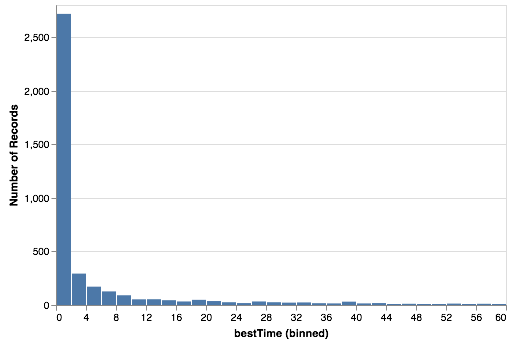

In [10]:
import pdvega
df[df['outcome'] != 'timeout']['bestTime'].vgplot.hist(bins=30)

In [11]:
df.groupby(['algorithm', 'hyperparams']).size()

algorithm  hyperparams      
FREQHORN   aggp                 516
           aggp-itp3            515
           freqs-aggp           515
           freqs-aggp-itp3      516
           v1                   516
           v1-eps               516
           v1-eps-freqs         516
           v1-eps-freqs-aggp    516
ICE                             215
MCMC                            314
Z3         spacerhyp1           495
           spacerhyp2           516
dtype: int64